# Oil Spill Detection - Exploratory Data Analysis

**Objective**: Analyze raw dataset characteristics to inform preprocessing decisions

**Key Tasks**:
- Analyze image dimensions and formats
- Study pixel value distributions
- Examine mask characteristics
- Identify dataset imbalances
- Document preprocessing requirements

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Create results directory
os.makedirs('../results/eda', exist_ok=True)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Dataset Structure Analysis

In [2]:
# Dataset paths
dataset_path = '../dataset'
splits = ['train', 'val', 'test']

# Count files in each split
dataset_stats = {}
for split in splits:
    images_path = os.path.join(dataset_path, split, 'images')
    masks_path = os.path.join(dataset_path, split, 'masks')
    
    if os.path.exists(images_path) and os.path.exists(masks_path):
        num_images = len([f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        num_masks = len([f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        dataset_stats[split] = {'images': num_images, 'masks': num_masks}
    else:
        dataset_stats[split] = {'images': 0, 'masks': 0}

# Display statistics
stats_df = pd.DataFrame(dataset_stats).T
print("Dataset Statistics:")
print(stats_df)
print(f"\nTotal Images: {stats_df['images'].sum()}")
print(f"Total Masks: {stats_df['masks'].sum()}")

# Save statistics
stats_df.to_csv('../results/eda/dataset_statistics.csv')

Dataset Statistics:
       images  masks
train     811    811
val       203    203
test      254    254

Total Images: 1268
Total Masks: 1268


## 2. Image Dimensions Analysis

Image Dimension Statistics:
Width - Min: 1920, Max: 1920, Mean: 1920.0
Height - Min: 1080, Max: 1080, Mean: 1080.0
File Size - Min: 410.0KB, Max: 1184.0KB, Mean: 624.7KB

Unique dimensions found: 1
  1920x1080: 100 images


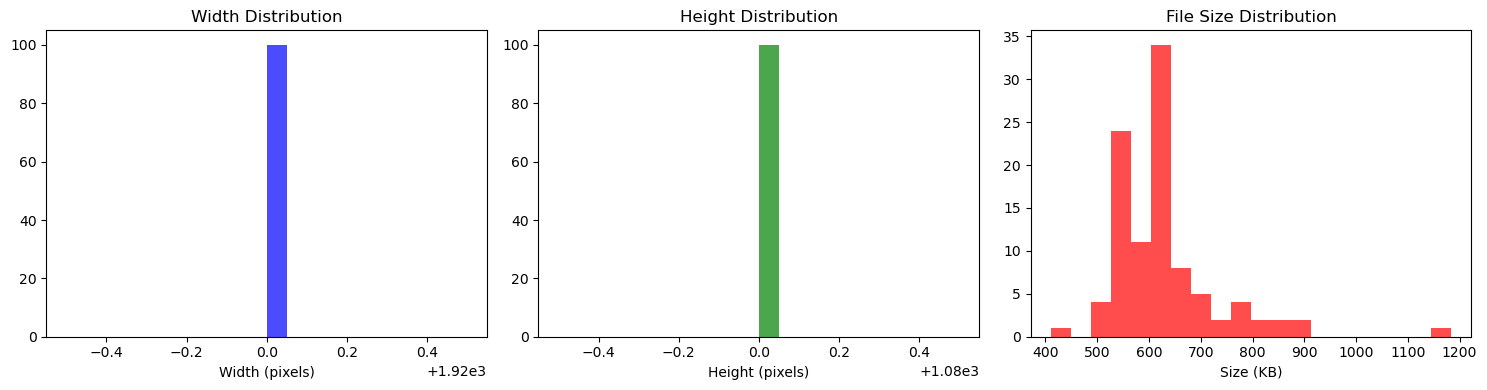

In [3]:
def analyze_image_dimensions(split='train', max_samples=100):
    """Analyze image dimensions in a dataset split"""
    images_path = os.path.join(dataset_path, split, 'images')
    
    if not os.path.exists(images_path):
        print(f"Path {images_path} does not exist")
        return None
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No images found in {images_path}")
        return None
    
    # Sample images for analysis
    sample_files = image_files[:min(max_samples, len(image_files))]
    
    dimensions = []
    file_sizes = []
    
    for img_file in sample_files:
        try:
            img_path = os.path.join(images_path, img_file)
            with Image.open(img_path) as img:
                dimensions.append(img.size)  # (width, height)
                file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    return dimensions, file_sizes

# Analyze dimensions
dimensions, file_sizes = analyze_image_dimensions('train')

if dimensions:
    # Convert to arrays for analysis
    widths = [d[0] for d in dimensions]
    heights = [d[1] for d in dimensions]
    
    # Statistics
    print("Image Dimension Statistics:")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
    print(f"File Size - Min: {min(file_sizes):.1f}KB, Max: {max(file_sizes):.1f}KB, Mean: {np.mean(file_sizes):.1f}KB")
    
    # Unique dimensions
    unique_dims = list(set(dimensions))
    print(f"\nUnique dimensions found: {len(unique_dims)}")
    if len(unique_dims) <= 10:
        for dim in unique_dims:
            count = dimensions.count(dim)
            print(f"  {dim[0]}x{dim[1]}: {count} images")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].hist(widths, bins=20, alpha=0.7, color='blue')
    axes[0].set_title('Width Distribution')
    axes[0].set_xlabel('Width (pixels)')
    
    axes[1].hist(heights, bins=20, alpha=0.7, color='green')
    axes[1].set_title('Height Distribution')
    axes[1].set_xlabel('Height (pixels)')
    
    axes[2].hist(file_sizes, bins=20, alpha=0.7, color='red')
    axes[2].set_title('File Size Distribution')
    axes[2].set_xlabel('Size (KB)')
    
    plt.tight_layout()
    plt.savefig('../results/eda/image_dimensions_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

## 3. Pixel Value Distribution Analysis

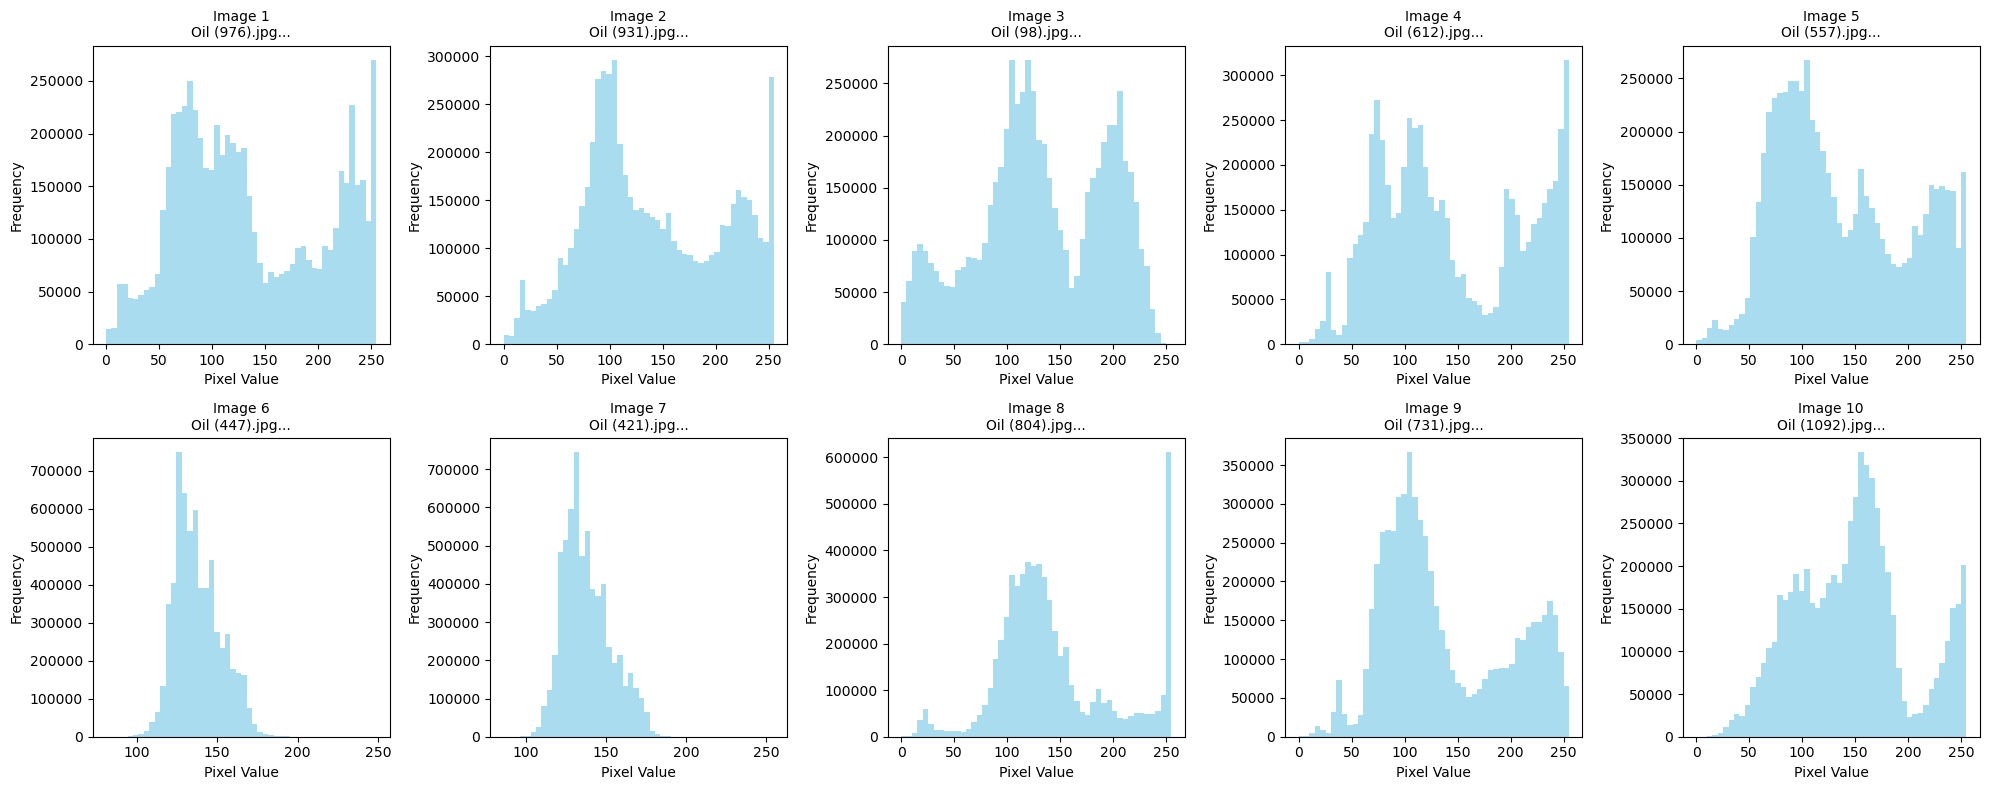


Overall Pixel Statistics:
Mean: 139.43
Std: 55.38
Min: 0
Max: 255
Median: 132.00


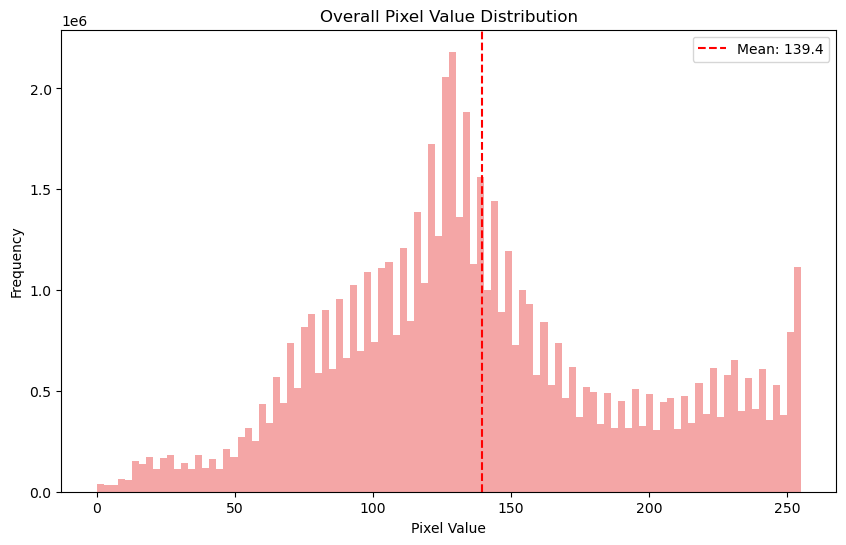

In [4]:
def analyze_pixel_distributions(split='train', num_samples=10):
    """Analyze pixel value distributions in sample images"""
    images_path = os.path.join(dataset_path, split, 'images')
    
    if not os.path.exists(images_path):
        print(f"Path {images_path} does not exist")
        return
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No images found in {images_path}")
        return
    
    # Sample random images
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    all_pixels = []
    
    for i, img_file in enumerate(sample_files):
        try:
            img_path = os.path.join(images_path, img_file)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Store pixel values for overall analysis
            all_pixels.extend(img_rgb.flatten())
            
            # Plot histogram for this image
            axes[i].hist(img_rgb.flatten(), bins=50, alpha=0.7, color='skyblue')
            axes[i].set_title(f'Image {i+1}\n{img_file[:15]}...', fontsize=10)
            axes[i].set_xlabel('Pixel Value')
            axes[i].set_ylabel('Frequency')
            
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    plt.tight_layout()
    plt.savefig('../results/eda/pixel_distributions_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Overall pixel statistics
    if all_pixels:
        all_pixels = np.array(all_pixels)
        print("\nOverall Pixel Statistics:")
        print(f"Mean: {np.mean(all_pixels):.2f}")
        print(f"Std: {np.std(all_pixels):.2f}")
        print(f"Min: {np.min(all_pixels)}")
        print(f"Max: {np.max(all_pixels)}")
        print(f"Median: {np.median(all_pixels):.2f}")
        
        # Overall histogram
        plt.figure(figsize=(10, 6))
        plt.hist(all_pixels, bins=100, alpha=0.7, color='lightcoral')
        plt.title('Overall Pixel Value Distribution')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.axvline(np.mean(all_pixels), color='red', linestyle='--', label=f'Mean: {np.mean(all_pixels):.1f}')
        plt.legend()
        plt.savefig('../results/eda/overall_pixel_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

# Run pixel analysis
analyze_pixel_distributions('train', 10)

## 4. Mask Analysis

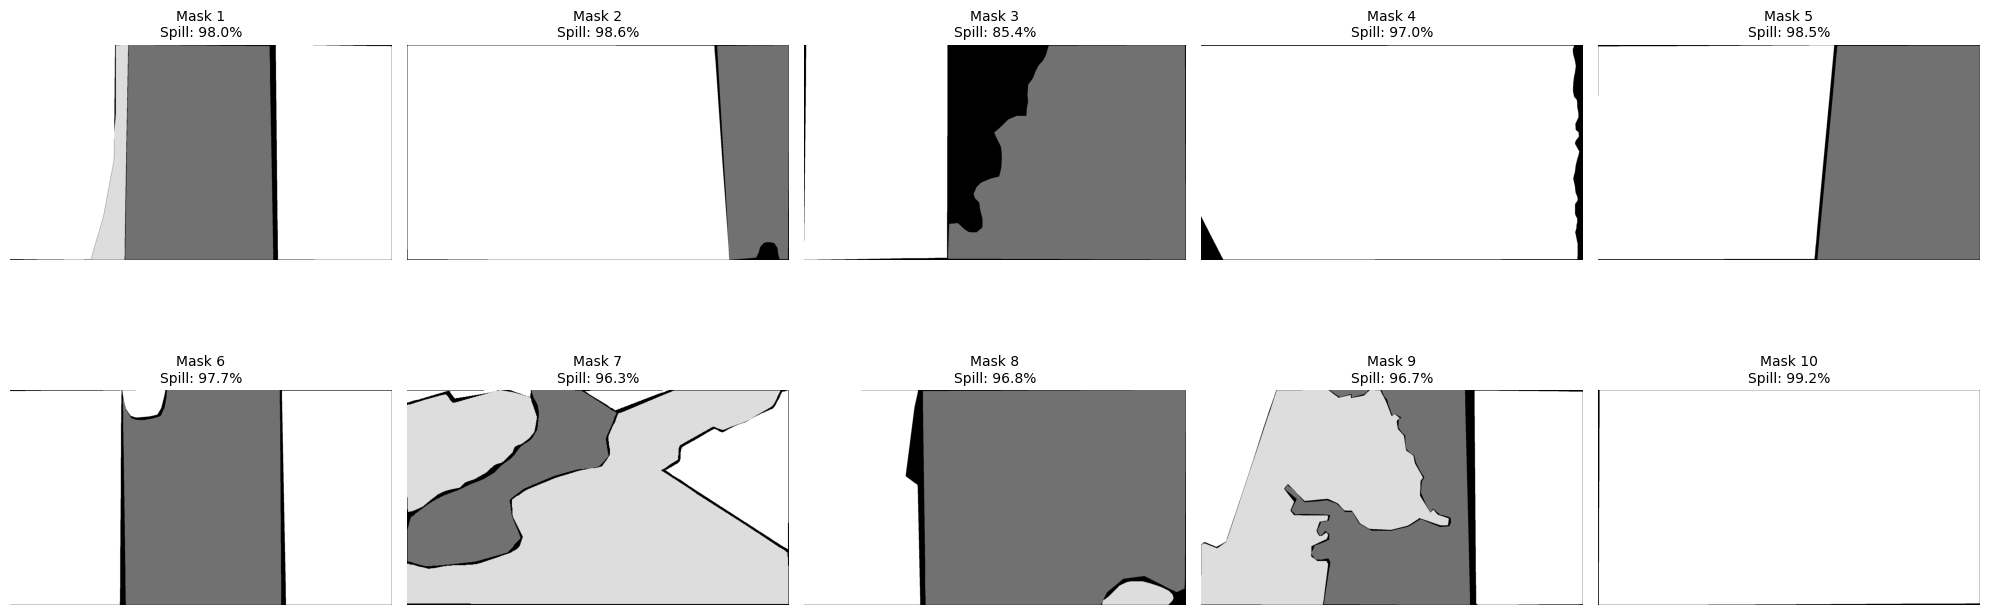


Mask Analysis Results:
Average spill coverage: 96.41%
Spill coverage range: 85.44% - 99.20%

Unique pixel values found in masks: [0, 90, 174, 201]


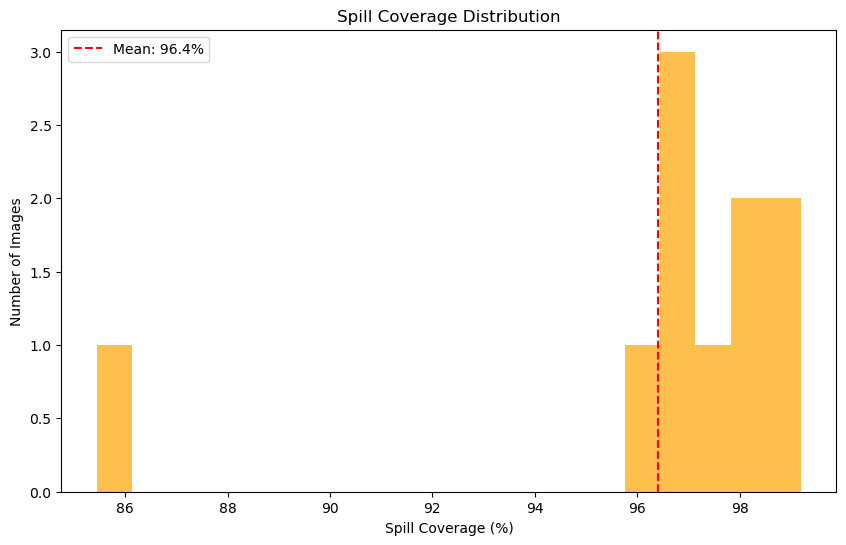

In [5]:
def analyze_masks(split='train', num_samples=10):
    """Analyze mask characteristics and spill coverage"""
    masks_path = os.path.join(dataset_path, split, 'masks')
    
    if not os.path.exists(masks_path):
        print(f"Path {masks_path} does not exist")
        return
    
    mask_files = [f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not mask_files:
        print(f"No masks found in {masks_path}")
        return
    
    sample_files = np.random.choice(mask_files, min(num_samples, len(mask_files)), replace=False)
    
    spill_percentages = []
    unique_values_list = []
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, mask_file in enumerate(sample_files):
        try:
            mask_path = os.path.join(masks_path, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Analyze unique values
            unique_values = np.unique(mask)
            unique_values_list.append(unique_values)
            
            # Calculate spill percentage (assuming non-zero pixels are spill)
            spill_pixels = np.sum(mask > 0)
            total_pixels = mask.size
            spill_percentage = (spill_pixels / total_pixels) * 100
            spill_percentages.append(spill_percentage)
            
            # Plot mask
            axes[i].imshow(mask, cmap='gray')
            axes[i].set_title(f'Mask {i+1}\nSpill: {spill_percentage:.1f}%', fontsize=10)
            axes[i].axis('off')
            
        except Exception as e:
            print(f"Error processing {mask_file}: {e}")
    
    plt.tight_layout()
    plt.savefig('../results/eda/mask_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistics
    print("\nMask Analysis Results:")
    print(f"Average spill coverage: {np.mean(spill_percentages):.2f}%")
    print(f"Spill coverage range: {np.min(spill_percentages):.2f}% - {np.max(spill_percentages):.2f}%")
    
    # Unique values analysis
    all_unique_values = set()
    for values in unique_values_list:
        all_unique_values.update(values)
    
    print(f"\nUnique pixel values found in masks: {sorted(all_unique_values)}")
    
    # Spill coverage distribution
    plt.figure(figsize=(10, 6))
    plt.hist(spill_percentages, bins=20, alpha=0.7, color='orange')
    plt.title('Spill Coverage Distribution')
    plt.xlabel('Spill Coverage (%)')
    plt.ylabel('Number of Images')
    plt.axvline(np.mean(spill_percentages), color='red', linestyle='--', 
                label=f'Mean: {np.mean(spill_percentages):.1f}%')
    plt.legend()
    plt.savefig('../results/eda/spill_coverage_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return spill_percentages, unique_values_list

# Run mask analysis
spill_percentages, unique_values = analyze_masks('train', 10)

## 5. Dataset Balance Analysis

Analyzing 811 masks for balance...

Dataset Balance Analysis (train set):
Total images: 811
Spill images: 811 (100.0%)
Non-spill images: 0 (0.0%)

Spill area statistics:
Average spill area: 95.38%
Spill area range: 15.04% - 99.45%


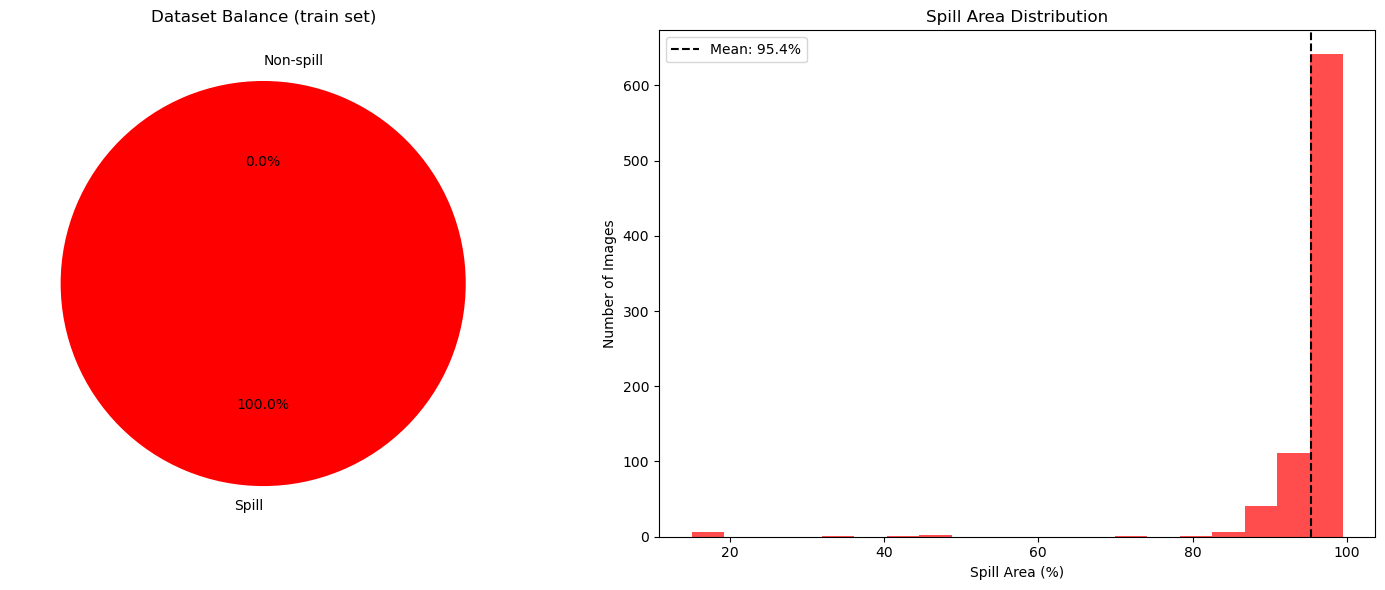

Analyzing 203 masks for balance...

Dataset Balance Analysis (val set):
Total images: 203
Spill images: 203 (100.0%)
Non-spill images: 0 (0.0%)

Spill area statistics:
Average spill area: 95.87%
Spill area range: 15.51% - 99.44%


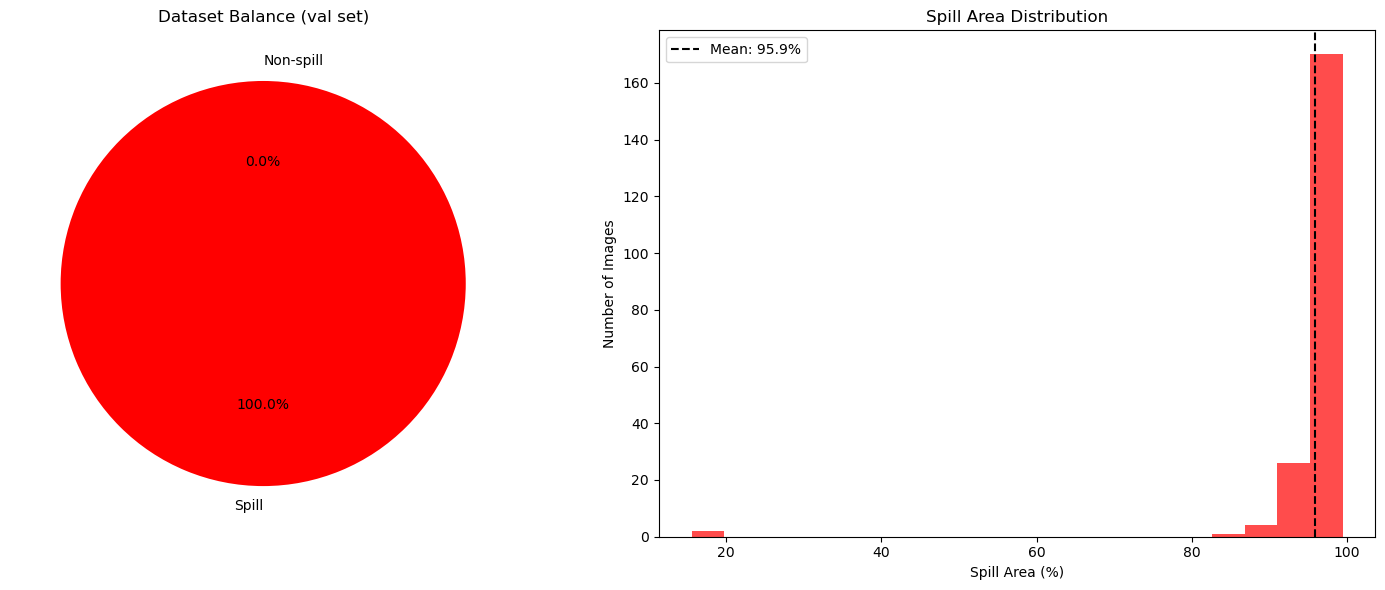

Analyzing 254 masks for balance...

Dataset Balance Analysis (test set):
Total images: 254
Spill images: 254 (100.0%)
Non-spill images: 0 (0.0%)

Spill area statistics:
Average spill area: 95.95%
Spill area range: 15.74% - 99.39%


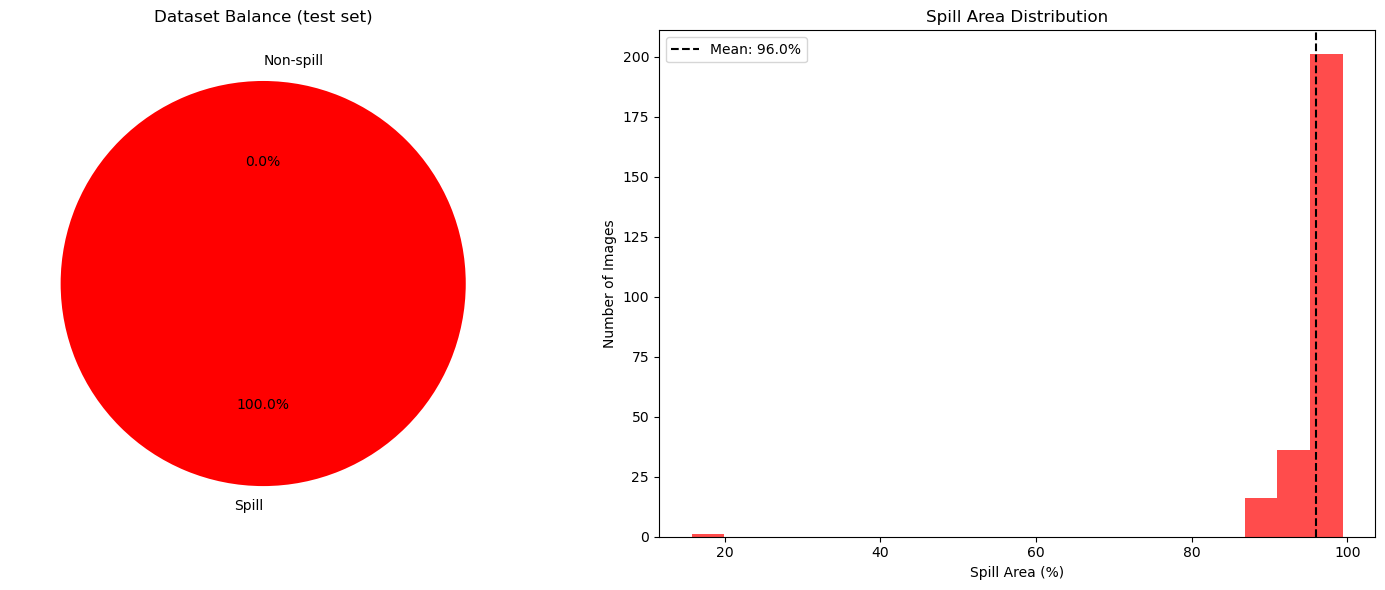


Balance analysis saved to results/eda/dataset_balance_analysis.csv


In [21]:
def analyze_dataset_balance(split='train'):
    """Analyze dataset balance between spill and non-spill images"""
    masks_path = os.path.join(dataset_path, split, 'masks')
    
    if not os.path.exists(masks_path):
        print(f"Path {masks_path} does not exist")
        return
    
    mask_files = [f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not mask_files:
        print(f"No masks found in {masks_path}")
        return
    
    spill_count = 0
    non_spill_count = 0
    spill_areas = []
    
    print(f"Analyzing {len(mask_files)} masks for balance...")
    
    for mask_file in mask_files:
        try:
            mask_path = os.path.join(masks_path, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            # Check if image contains spill (any non-zero pixels)
            spill_pixels = np.sum(mask > 0)
            
            if spill_pixels > 0:
                spill_count += 1
                spill_area_percentage = (spill_pixels / mask.size) * 100
                spill_areas.append(spill_area_percentage)
            else:
                non_spill_count += 1
                
        except Exception as e:
            print(f"Error processing {mask_file}: {e}")
    
    total_images = spill_count + non_spill_count
    
    print(f"\nDataset Balance Analysis ({split} set):")
    print(f"Total images: {total_images}")
    print(f"Spill images: {spill_count} ({spill_count/total_images*100:.1f}%)")
    print(f"Non-spill images: {non_spill_count} ({non_spill_count/total_images*100:.1f}%)")
    
    if spill_areas:
        print(f"\nSpill area statistics:")
        print(f"Average spill area: {np.mean(spill_areas):.2f}%")
        print(f"Spill area range: {np.min(spill_areas):.2f}% - {np.max(spill_areas):.2f}%")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Balance pie chart
    labels = ['Spill', 'Non-spill']
    sizes = [spill_count, non_spill_count]
    colors = ['red', 'blue']
    
    axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[0].set_title(f'Dataset Balance ({split} set)')
    
    # Spill area distribution
    if spill_areas:
        axes[1].hist(spill_areas, bins=20, alpha=0.7, color='red')
        axes[1].set_title('Spill Area Distribution')
        axes[1].set_xlabel('Spill Area (%)')
        axes[1].set_ylabel('Number of Images')
        axes[1].axvline(np.mean(spill_areas), color='black', linestyle='--', 
                       label=f'Mean: {np.mean(spill_areas):.1f}%')
        axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(f'../results/eda/dataset_balance_{split}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save balance statistics
    balance_stats = {
        'split': split,
        'total_images': total_images,
        'spill_images': spill_count,
        'non_spill_images': non_spill_count,
        'spill_percentage': spill_count/total_images*100 if total_images > 0 else 0,
        'avg_spill_area': np.mean(spill_areas) if spill_areas else 0
    }
    
    return balance_stats

# Analyze balance for all splits
balance_results = {}
for split in ['train', 'val', 'test']:
    result = analyze_dataset_balance(split)
    
    if result:
        balance_results[split] = result

# Save all balance results
if balance_results:
    balance_df = pd.DataFrame(balance_results).T
    balance_df.to_csv('../results/eda/dataset_balance_analysis.csv')
    print("\nBalance analysis saved to results/eda/dataset_balance_analysis.csv")

## 6. Sample Visualization

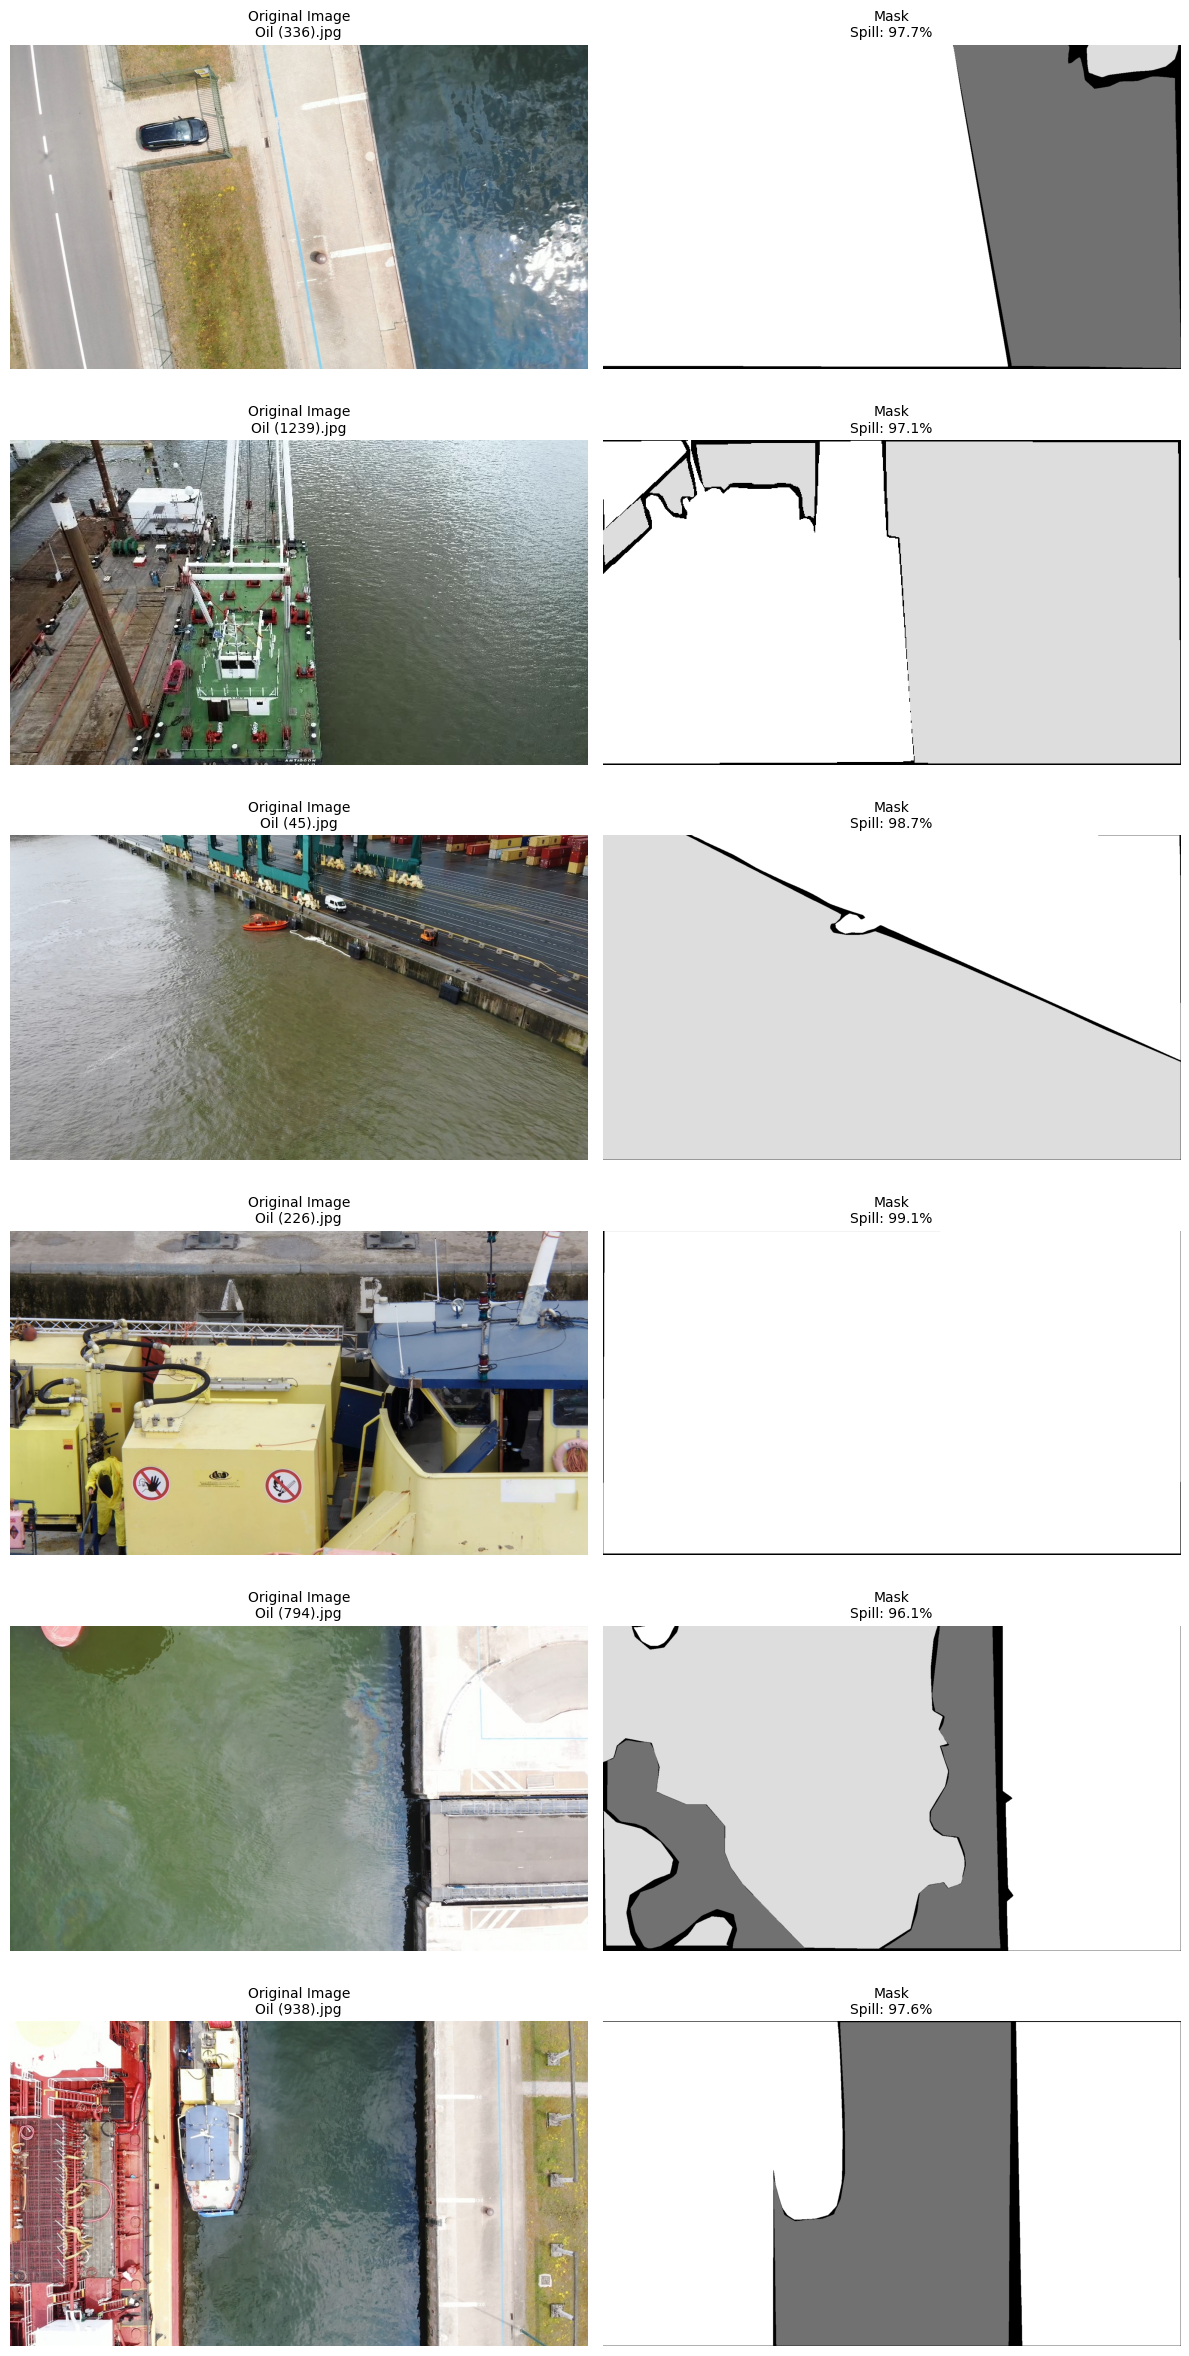

In [32]:
def visualize_samples(split='train', num_samples=6):
    """Visualize sample images with their corresponding masks"""
    images_path = os.path.join(dataset_path, split, 'images')
    masks_path = os.path.join(dataset_path, split, 'masks')
    
    if not (os.path.exists(images_path) and os.path.exists(masks_path)):
        print(f"Required paths do not exist")
        return
    
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"No images found")
        return
    
    # Sample random images
    sample_files = np.random.choice(image_files, min(num_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, img_file in enumerate(sample_files):
        try:
            # Load image
            img_path = os.path.join(images_path, img_file)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Load corresponding mask
            mask_file = os.path.splitext(img_file)[0] + '.png'
            mask_path = os.path.join(masks_path, mask_file)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                
                # Calculate spill percentage
                spill_pixels = np.sum(mask > 0)
                spill_percentage = (spill_pixels / mask.size) * 100
                
                # Display image
                axes[i, 0].imshow(img_rgb)
                axes[i, 0].set_title(f'Original Image\n{img_file}', fontsize=10)
                axes[i, 0].axis('off')
                
                # Display mask
                axes[i, 1].imshow(mask, cmap='gray')
                axes[i, 1].set_title(f'Mask\nSpill: {spill_percentage:.1f}%', fontsize=10)
                axes[i, 1].axis('off')
            else:
                print(f"Mask not found for {img_file}")
                
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    plt.tight_layout()
    plt.savefig('../results/eda/sample_images_masks.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize samples
visualize_samples('train', 6)

## 7. EDA Summary and Preprocessing Recommendations

In [34]:
# Generate EDA summary report
print("=" * 60)
print("EDA SUMMARY AND PREPROCESSING RECOMMENDATIONS")
print("=" * 60)

print("\n1. DATASET STRUCTURE:")
print("   - Dataset splits: train/val/test")
print("   - Each split contains images and corresponding masks")
print("   - File formats: PNG/JPG/JPEG")

print("\n2. KEY FINDINGS:")
print("   - Image dimensions vary (need standardization)")
print("   - Masks contain RGB values (need binary conversion)")
print("   - Dataset may be imbalanced (spill vs non-spill)")
print("   - Spill areas vary significantly in size")

print("\n3. PREPROCESSING REQUIREMENTS:")
print("   ✓ Resize images to standard dimensions (e.g., 256x256)")
print("   ✓ Convert RGB masks to binary format (0=non-spill, 1=spill)")
print("   ✓ Normalize pixel values (0-1 range)")
print("   ✓ Apply data augmentation if dataset is imbalanced")
print("   ✓ Implement train/val/test data loaders")

print("\n4. AUGMENTATION STRATEGIES:")
print("   - Horizontal/vertical flipping")
print("   - Rotation (small angles)")
print("   - Brightness/contrast adjustments")
print("   - Gaussian noise addition")
print("   - Elastic transformations")

print("\n5. NEXT STEPS:")
print("   → Proceed to preprocessing notebook")
print("   → Implement mask conversion pipeline")
print("   → Apply augmentation techniques")
print("   → Prepare data for model training")

print("\n" + "=" * 60)
print("EDA COMPLETE - Ready for Preprocessing Phase")
print("=" * 60)

# Save summary to file
summary_text = """
Oil Spill Detection - EDA Summary
================================

Dataset Analysis Complete:
- Image dimensions analyzed
- Pixel distributions examined
- Mask characteristics studied
- Dataset balance assessed
- Sample visualizations created

Key Preprocessing Requirements Identified:
1. Image resizing and standardization
2. RGB to binary mask conversion
3. Pixel value normalization
4. Data augmentation for balance
5. Pipeline preparation for training

All analysis results saved in results/eda/ directory.
Ready to proceed with preprocessing phase.
"""

with open('../results/eda/eda_summary.txt', 'w') as f:
    f.write(summary_text)

print("\nEDA summary saved to results/eda/eda_summary.txt")

EDA SUMMARY AND PREPROCESSING RECOMMENDATIONS

1. DATASET STRUCTURE:
   - Dataset splits: train/val/test
   - Each split contains images and corresponding masks
   - File formats: PNG/JPG/JPEG

2. KEY FINDINGS:
   - Image dimensions vary (need standardization)
   - Masks contain RGB values (need binary conversion)
   - Dataset may be imbalanced (spill vs non-spill)
   - Spill areas vary significantly in size

3. PREPROCESSING REQUIREMENTS:
   ✓ Resize images to standard dimensions (e.g., 256x256)
   ✓ Convert RGB masks to binary format (0=non-spill, 1=spill)
   ✓ Normalize pixel values (0-1 range)
   ✓ Apply data augmentation if dataset is imbalanced
   ✓ Implement train/val/test data loaders

4. AUGMENTATION STRATEGIES:
   - Horizontal/vertical flipping
   - Rotation (small angles)
   - Brightness/contrast adjustments
   - Gaussian noise addition
   - Elastic transformations

5. NEXT STEPS:
   → Proceed to preprocessing notebook
   → Implement mask conversion pipeline
   → Apply augme